# Logistic Regression

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import networkx as nx
import dowhy
import pandas as pd
from dowhy import CausalModel

style.use('fivethirtyeight') # bmh

import math
import dowhy.datasets, dowhy.plotter

import hyppo
import pingouin as pg
import conditional_independence
from helpers import *
from hyppo.independence import Hsic

# the code below simple hides some warnings we don't want to see
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)


# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

path = "Data/lucas0_text/"
names = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing']


# reading csv files
train =  pd.read_csv(path + 'lucas0_train.data', sep=" ", header = None)
train.drop(11, inplace = True, axis = 1)
train.columns = names
test =  pd.read_csv(path + 'lucas0_test.data', sep=" ", header = None)
test.drop(11, inplace = True, axis = 1)
test.columns = names
target =  pd.read_csv(path + 'lucas0_train.targets', sep=" ", header = None)
# param =  pd.read_csv(path + 'lucas0.param', sep=" ")

target[target[0] == -1] = 0

avgs = train[names].mean()

train["Lung_Cancer"] = np.array(target)

avgs = train.mean()


In [5]:
train

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


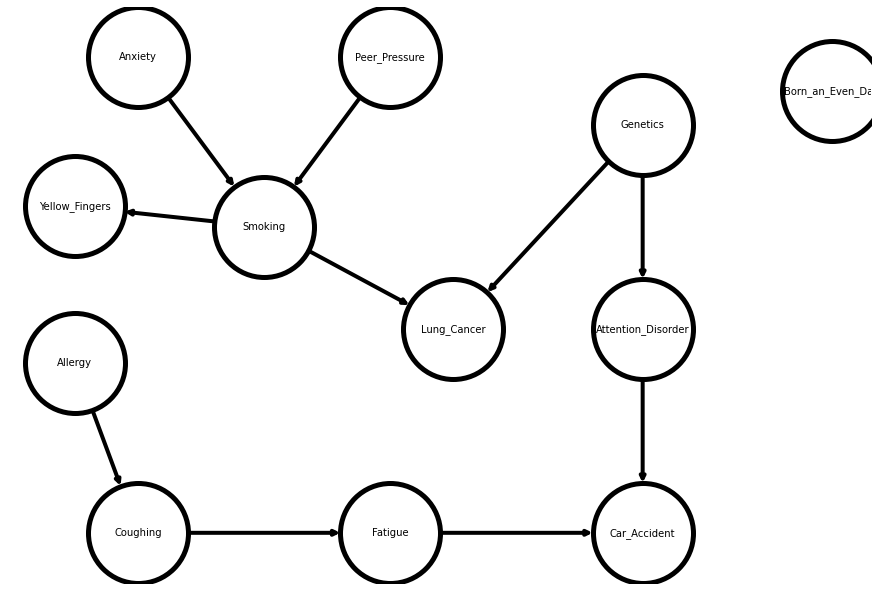

In [35]:
# we import networkx and create a directed graph
G = nx.DiGraph()

plt.figure(3,figsize=(12,8))

G.add_nodes_from(['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing', 'Lung_Cancer'])

#LungCancer to Coughing deleted
# G.add_edges_from([('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_Cancer'), 
#                   ('Allergy','Coughing'), ('Coughing','Fatigue'), ('Lung_Cancer','Fatigue'),
#                  ('Genetics','Lung_Cancer'), ('Genetics','Attention_Disorder'), ('Attention_Disorder', 'Car_Accident'), ('Fatigue', 'Car_Accident')])

#LungCancer to Coughing + Lung Cancer to Fatigue deleted 
G.add_edges_from([('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_Cancer'), 
                  ('Allergy','Coughing'), ('Coughing','Fatigue'),
                 ('Genetics','Lung_Cancer'), ('Genetics','Attention_Disorder'), ('Attention_Disorder', 'Car_Accident'), ('Fatigue', 'Car_Accident')])

#Lung Cancer to Fatigue deleted 
#G.add_edges_from([('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_Cancer'), 
                #   ('Allergy','Coughing'), ('Coughing','Fatigue'), ('Lung_Cancer','Coughing'),
                #  ('Genetics','Lung_Cancer'), ('Genetics','Attention_Disorder'), ('Attention_Disorder', 'Car_Accident'), ('Fatigue', 'Car_Accident')])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear) 
# and save it to a .gml format (for using DoWhy later)
pos = {'Anxiety': (-20, 40),              'Yellow_Fingers': (-25, 18),
         'Peer_Pressure': (0, 40), 'Smoking': (-10, 15), 'Allergy': (-25, -5),
         'Coughing': (-20, -30), 'Lung_Cancer': (5, 0), 'Genetics': (20, 30), 'Attention_Disorder': (20, 0),
         'Fatigue': (0, -30),'Car_Accident': (20, -30), 'Born_an_Even_Day' : (35,35)}

nx.draw(G, pos = pos,with_labels=True, node_size=10000, node_color='w', edgecolors ='black', linewidths= 5, width = 4, font_size = 10)
nx.write_gml(G, "backdoor_criterion_graph.gml")

plt.show()

In [7]:
train

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [26]:
get_adjustment_variables(G, get_backdoor_paths(G, 'Coughing', 'Car_Accident'))

,path,colliders_desc,non_colliders
0,"[Coughing, Lung_Cancer, Genetics, Attention_Di...",[],"[Lung_Cancer, Genetics, Attention_Disorder]"


# Estimating Causal Effect 

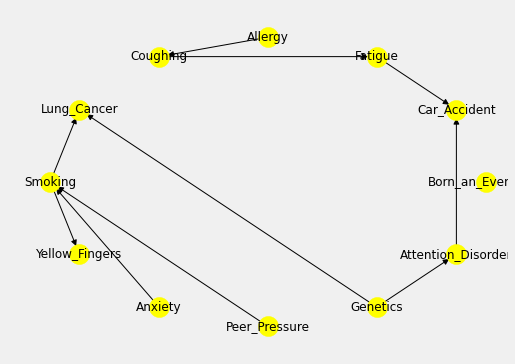

In [36]:
import dowhy
import pandas as pd
from dowhy import CausalModel

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
        data = train, # df
        treatment='Coughing',
        outcome='Car_Accident',
        graph=gml_graph
        )
model.view_model()


In [29]:
get_frontdoor_sets(model)

['Fatigue']

In [37]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                
───────────(Expectation(Car_Accident))
d[Coughing]                           
Estimand assumption 1, Unconfoundedness: If U→{Coughing} and U→Car_Accident then P(Car_Accident|Coughing,,U) = P(Car_Accident|Coughing,)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Car_Accident, [Allergy])*Derivative([Coughing], [Allerg
y])**(-1))
Estimand assumption 1, As-if-random: If U→→Car_Accident then ¬(U →→{Allergy})
Estimand assumption 2, Exclusion: If we remove {Allergy}→{Coughing}, then ¬({Allergy}→Car_Accident)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(Car_Accident, [Fatigue])*Derivative([Fatigue], [Coughin
g]))
Estimand assumption 1, Full-mediation: Fatigue intercepts (blocks) all directed paths from Coughing to C,a,r,_,A,c,c,i,d,e,n,t.
Estimand assumption 2, First-stage-unconfoundedne

# Logistic Regression

In [4]:
# we first use only v0 and y
# we need to reshape them into the correct shape for our linear regression function
v0_vals = train['Coughing'].values.reshape(len(train['Coughing']), 1) # x
y_vals = train['Car_Accident'].values.reshape(len(train['Car_Accident']), 1) # Predcition y

In [5]:
# we import the LinearRegression object from sklearn
from sklearn.linear_model import LogisticRegression

# we fit a linear regression model with v0 and y, and check what the estimated linear effect is
log_regressor = LogisticRegression() 
log_regressor.fit(v0_vals, y_vals)
print(log_regressor.coef_) # We see that this is not correct, it is too small!
print(log_regressor.intercept_)

[[0.93930241]]
[0.34006295]


In [6]:
# we first collect the extra variables we wish to include
W0_vals = train['Lung_Cancer'].values.reshape(len(train['Lung_Cancer']), 1)

# we need to combine all of the variables we're including into one array
backdoor = np.concatenate((v0_vals, W0_vals), axis = 1)


In [7]:
# we fit the linear regression with the extra variables included
log_regressor.fit(backdoor, y_vals)
print(log_regressor.coef_)
print(log_regressor.intercept_)

[[0.7377658  0.40607405]]
[0.19306796]


In [8]:
print(log_regressor.coef_)
print(log_regressor.intercept_)

[[0.7377658  0.40607405]]
[0.19306796]


In [38]:
import statsmodels.api as sm

causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.generalized_linear_model",
                                       confidence_intervals=True,
                                       test_significance=True,
                                        method_params = {
                                            'num_null_simulations':10,
                                            'num_simulations':10,
                                            'num_quantiles_to_discretize_cont_cols':10,
                                            'fit_method': "statsmodels",
                                            'glm_family': sm.families.Binomial(), # logistic regression
                                            'need_conditional_estimates':False
                                        },
                                       )

In [39]:
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                
───────────(Expectation(Car_Accident))
d[Coughing]                           
Estimand assumption 1, Unconfoundedness: If U→{Coughing} and U→Car_Accident then P(Car_Accident|Coughing,,U) = P(Car_Accident|Coughing,)

## Realized estimand
b: Car_Accident~Sigmoid(Coughing+Coughing*Attention_Disorder+Coughing*Genetics)
Target units: ate

## Estimate
Mean value: 0.1946957375833861
p-value: [0, 0.1]
95.0% confidence interval: (0.17171758128714942, 0.21833076978828547)

Causal Estimate is 0.1946957375833861


In [11]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random) 
# Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

Refute: Add a random common cause
Estimated effect:0.15785190742002486
New effect:0.15775969574093124
p value:0.45999999999999996



In [12]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="add_unobserved_common_cause")
print(res_random)
#  How sensitive is the effect estimate when we add an additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? 
# # (Hint: It should not be too sensitive)

Refute: Add an Unobserved Common Cause
Estimated effect:0.15785190742002486
New effect:0.1024082738975054



In [13]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="data_subset_refuter")
print(res_random)

# Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

Refute: Use a subset of data
Estimated effect:0.15785190742002486
New effect:0.15991829307506586
p value:0.47



In [15]:
print(causal_estimate.estimator.model.summary())
causal_estimate.interpret()

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Car_Accident   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1065.9
Date:                Fri, 18 Mar 2022   Deviance:                       2131.7
Time:                        09:28:59   Pearson chi2:                 2.00e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1080
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2090      0.094      2.212      0.0

In [16]:

log_regressor.predict(train[['Coughing', 'Lung_Cancer']])

log_regressor.score(train[['Coughing', 'Lung_Cancer']], train['Car_Accident'])

/opt/anaconda3/envs/CDS/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/CDS/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Making Predictions With Test Set


In [16]:
# we first collect the extra variables we wish to include
W0_vals = train['Lung_Cancer'].values.reshape(len(train['Lung_Cancer']), 1)

# we need to combine all of the variables we're including into one array
backdoor = np.concatenate((v0_vals, W0_vals), axis = 1)
backdoor

array([[0, 0],
       [1, 1],
       [1, 1],
       ...,
       [0, 1],
       [1, 1],
       [1, 1]])

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

x_train,x_test,y_train,y_test = train_test_split(backdoor,y_vals,test_size=0.2, random_state=0)

In [21]:
# we fit the linear regression with the extra variables included
log_regressor1 = LogisticRegression(max_iter = 1000) 

# ct = make_column_transformer(
#     (MinMaxScaler(), ), 
#     (StandardScaler(), ),
#     remainder='passthrough'
# )

# x_train = ct.fit_transform(x_train)
# x_test = ct.transform(x_test)


log_regressor1.fit(x_train, y_train)
log_regressor1.coef_

/opt/anaconda3/envs/CDS/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0.77547529, 0.37288989]])

In [22]:
pred = log_regressor1.predict(x_test)


In [23]:
score = log_regressor1.score(x_test, y_test)
print(score)

0.7475


In [24]:
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

[[  0 101]
 [  0 299]]


In [25]:
pd.DataFrame(pred).value_counts()

1    400
dtype: int64

In [26]:
train

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [27]:
num_columns = ['Coughing', 'Lung_Cancer', 'Fatigue']

x = train[num_columns]
y = train['Car_Accident']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

lr = LogisticRegression(max_iter = 1000)

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

lr.fit(x_train, y_train)

predictions = lr.predict(x_test)
score = lr.score(x_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

0.8025
[[ 63  38]
 [ 41 258]]


# Prediction of the whole Thing

In [28]:
num_columns = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing']

x = train[num_columns]
y = train['Lung_Cancer']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

lr = LogisticRegression(max_iter = 1000)

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

lr.fit(x_train, y_train)

predictions = lr.predict(x_test)
score = lr.score(x_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

0.8475
[[ 81  36]
 [ 25 258]]


In [29]:
pd.DataFrame(predictions).value_counts()

1    294
0    106
dtype: int64

In [30]:
294 / (294+106)

In [69]:
num_columns = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing']

x = train[num_columns]
y = train['Lung_Cancer']

lr = LogisticRegression(max_iter = 1000)


lr.fit(x, y)


LogisticRegression(max_iter=1000)

In [70]:

predictions = lr.predict(test)


In [72]:
pd.DataFrame(predictions).value_counts()

1    7597
0    2403
dtype: int64

In [73]:
7597 / (7597 + 2403)

In [ ]:
score = lr.score(x_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

In [37]:
%matplotlib inline
import numpy as np
import pylab as pl
from numpy.random import uniform
from numpy import exp
from scipy.special import expit as sigmoid, logit
# from arsenal.timer import timers    # https://github.com/timvieira/arsenal
    

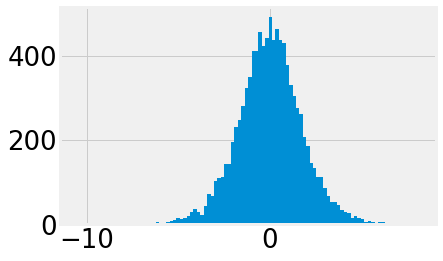

In [54]:
from scipy.stats import logistic
u = uniform(0,1,size=10000)
z = logit(u)
pl.hist(z, bins=100)
xs = np.linspace(-6,6,100)
ys = logistic.pdf(xs, np.mean(train['Lung_Cancer']), np.std(train['Lung_Cancer']))
pl.plot(xs, ys, c='r', lw=2)

In [39]:
u

array([0.35881169, 0.07696507, 0.31782175, ..., 0.30788697, 0.10076139,
       0.37965005])

In [40]:
np.random.logistic(loc = 0, scale= 0.1, size= 10)

array([ 0.23154112, -0.20020741,  0.0425098 , -0.11651847,  0.15060654,
        0.05106999,  0.31145996,  0.10166205, -0.3110498 , -0.16254382])

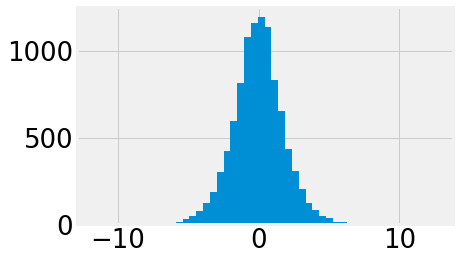

In [45]:
import matplotlib.pyplot as plt
loc, scale = 0, 1
s = np.random.logistic(loc, scale, 10000)
count, bins, ignored = plt.hist(s, bins=50)

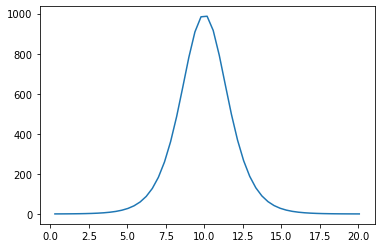

In [23]:
def logist(x, loc, scale):
     return exp((loc-x)/scale)/(scale*(1+exp((loc-x)/scale))**2)
plt.plot(bins, logist(bins, loc, scale)*count.max()/\
logist(bins, loc, scale).max())
plt.show()

In [50]:
x = np.arange(-1, 1,0.25)

for i in x:
    print(logistic.cdf(i, 0 , 1))


0.2689414213699951
0.320821300824607
0.3775406687981454
0.43782349911420193
0.5
0.5621765008857981
0.6224593312018546
0.679178699175393
